# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=8)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|████████████████████████| 170498071/170498071 [00:43<00:00, 3883866.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

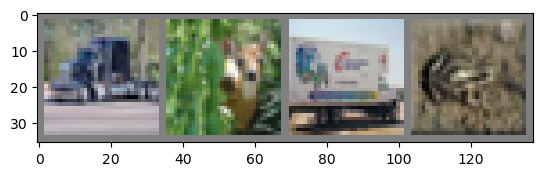

truck deer truck frog


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [72]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # <your code here>
        self.conv_block = nn.Sequential( # (3, 32, 32)
            nn.Conv2d(in_channels=3, 
                      out_channels=32, 
                      kernel_size=3,
                     padding=1), # (32, 32, 32)
            nn.BatchNorm2d(32), # (32, 32, 32)
            nn.ReLU(), # (32, 32, 32)
            nn.Conv2d(in_channels=32, 
                      out_channels=32,
                     kernel_size=3,
                     padding=1), # (32, 32, 32)
            nn.BatchNorm2d(32) # (32, 32, 32)
        )
        self.relu = nn.ReLU() # (32, 32, 32)
        self.avgpool = nn.AvgPool2d((8,8)) # (32, 4, 4)

        self.conv11 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size=1,
                               padding=0)
        self.classifier = nn.Linear(in_features=512, out_features=10)
        

    def forward(self, x):
        out = self.avgpool(self.relu(self.conv_block(x) + self.conv11(x)))
        out = out.reshape(x.shape[0], 512)
        out = self.classifier(out)
        return out

In [94]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (conv11): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)

In [95]:
from torchsummary import summary
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 32, 32, 32]             128
              ReLU-7           [-1, 32, 32, 32]               0
         AvgPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                   [-1, 10]           5,130
Total params: 15,530
Trainable params: 15,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.75
Params size (MB): 0.06
Estimated Total Size (MB): 1.82
---------------------------------------------

Проверим, что выход сети имеет корректную размерность:

In [96]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [97]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

In [98]:
# Выбор ускорителя для Apple Silicon / Cuda / CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


print(device)

mps


In [99]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [100]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        # <your code here>

        data = data.to(device)
        target = target.to(device)

        logits = model(data)
        loss = criterion(logits, target)
        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item()) 
        # <your code here>
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        
        # <your code here>

        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()

        logits = model(data)

        loss = criterion(logits, target)
        acc = (logits.argmax(dim=1) == target).sum() / target.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item()) 

        loss.backward()
        optimizer.step()
        
        # <your code here>

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [101]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4698663973939048, train acc: 0.4791435427160106
 val loss: 1.199511922927613, val acc: 0.5809175531914894

Epoch 1
 train loss: 1.1624027063467386, train acc: 0.5917382149853262
 val loss: 1.1510753182654685, val acc: 0.5951241134329045

Epoch 2
 train loss: 1.0640869190749564, train acc: 0.6306313658763112
 val loss: 1.0705453682453074, val acc: 0.6321586880278081

Epoch 3
 train loss: 1.0008396939995956, train acc: 0.6546177200469064
 val loss: 0.9934170951234533, val acc: 0.6538785460147452

Epoch 4
 train loss: 0.9684448257442803, train acc: 0.6654356555703353
 val loss: 1.0161621910460452, val acc: 0.6455230497299357

Epoch 5
 train loss: 0.9383791900857928, train acc: 0.6757149385795733
 val loss: 0.9492551915189054, val acc: 0.6680851063829787

Epoch 6
 train loss: 0.9094194761141998, train acc: 0.6847577696526508
 val loss: 0.937366204566144, val acc: 0.6811391843126176

Epoch 7
 train loss: 0.8862329098162747, train acc: 0.693572081530116
 val loss: 0.94

Посчитайте точность на тестовой выборке:

In [102]:
# <your code here>
_, acc = test(net, test_loader)
print(acc)

0.6839171974522293


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [103]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.480046394320249, train acc: 0.4746466113400852
 val loss: 1.2869361854614096, val acc: 0.5511081561129144

Epoch 1
 train loss: 1.1428947211183622, train acc: 0.6034906307129799
 val loss: 1.154633402570765, val acc: 0.5926196808510639

Epoch 2
 train loss: 1.0427819919760528, train acc: 0.6391028989603577
 val loss: 1.1587484542359696, val acc: 0.5927969857733301

Epoch 3
 train loss: 0.9907502425218195, train acc: 0.6562581613687101
 val loss: 0.9986124365887743, val acc: 0.6567597518575953

Epoch 4
 train loss: 0.9547749391639473, train acc: 0.6685614716636198
 val loss: 1.019934571042974, val acc: 0.6465868793903513

Epoch 5
 train loss: 0.9224343475301697, train acc: 0.6786571232230834
 val loss: 0.9599487441651364, val acc: 0.6699468085106383

Epoch 6
 train loss: 0.9043752139185639, train acc: 0.6860513514966807
 val loss: 1.0154011972407078, val acc: 0.6577792553191489

Epoch 7
 train loss: 0.883279795729482, train acc: 0.6953879929329839
 val loss: 0.983

Посчитайте точность на тестовой выборке:

In [104]:
# <your code here>
_, acc = test(net, test_loader)
print(acc)

0.7137738853503185


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
# <your code here>

In [105]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8318851780847831, train acc: 0.3557880647766525
 val loss: 1.5997792629485434, val acc: 0.4490691489361702

Epoch 1
 train loss: 1.522926719140745, train acc: 0.4661914011024252
 val loss: 1.4399800549162196, val acc: 0.4921542553191489

Epoch 2
 train loss: 1.4046643290266911, train acc: 0.5066148146196955
 val loss: 1.3475341482365386, val acc: 0.5258200355032657

Epoch 3
 train loss: 1.331447128403993, train acc: 0.5353919104204753
 val loss: 1.3063668682220135, val acc: 0.5387632978723405

Epoch 4
 train loss: 1.2799851656831815, train acc: 0.5516045312558929
 val loss: 1.2643730914339106, val acc: 0.5540780142266699

Epoch 5
 train loss: 1.2416486912279285, train acc: 0.5660910159621858
 val loss: 1.2271213201766318, val acc: 0.5690602837724889

Epoch 6
 train loss: 1.2060107271675653, train acc: 0.5784759401621287
 val loss: 1.1855592631279155, val acc: 0.5877437942839684

Epoch 7
 train loss: 1.1720726768974847, train acc: 0.5908975907391997
 val loss: 1.1

In [106]:
_, acc = test(net, test_loader)
print(acc)

0.6639132165605095


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
# <your code here>

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>